<a href="https://colab.research.google.com/github/heugyu/coin_deep_learning/blob/master/DataAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [93]:
# GEN DATASET

import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

import matplotlib
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error

print(torch.__version__)
%matplotlib inline
%pylab inline
pylab.rcParams['figure.figsize'] = (18, 10)

1.4.0
Populating the interactive namespace from numpy and matplotlib


In [94]:
# 구글 드라이브 csv read
data = pd.read_csv('/content/drive/My Drive/DATA/BITSTAMP_BTCUSD_30.csv')
print(f'데이터 shape : {data.shape}')
data.head()

데이터 shape : (20642, 61)


,time,open,high,low,close,Mean,Upper,Lower,Upper fib,low fib,Plot,Plot.1,Plot.2,ParabolicSAR,H,M,L,wca,RES,SUP,Shapes,Shapes.1,EMA_34,EMA_90,EMA_100,EMA_144,EMA_200,short_line,RES.1,RES_CLOSE,SUP.1,SUP_CLOSE,VWAP,34 EMA,Volume,Volume MA,Bitfinex (USD),Coinbase (USD),Bitstamp (USD),Kraken (USD),HitBTC (USD),CEX.io (USD),Binance (USDT),Bittrex (USDT),Poloniex (USDT),bitFlyer (JPY),Bithumb (KRW),Korbit (KRW),Kraken (EUR),Bitfinex (EUR),Bitstamp (EUR),Coinbase (EUR),Volume.1,A/D Volume,Volume EMA,A/D Volume EMA,A/D Buy MA,A/D Sell MA,OnBalanceVolume,MF,Accumulation/Distribution
0,1546300800,3693.85,3698.79,3683.45,3688.85,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,3690.363333,3772.823236,33.633692,NaN,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,7.277663e+07,0.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,-9.954170
1,1546302600,3688.85,3703.25,3688.85,3693.83,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3683.4500,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,3693.548804,3772.823236,60.833166,NaN,407313.261684,681330.350910,77222.072074,140835.504549,8.689055e+05,6557.405676,803971.883778,985416.710187,18827.759069,228461.856712,61138.190113,19330.049509,0.0,0.0,0.0,0.0,8.162056e+07,5.062764e+08,NaN,NaN,NaN,NaN,60.833166,NaN,-28.711062
2,1546304400,3692.89,3699.35,3685.34,3691.65,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3683.4500,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,3692.981234,3772.823236,61.777367,NaN,19211.177974,423231.053272,52043.157477,43685.080807,9.086327e+04,981.107861,226684.675153,484473.694572,402.920974,111388.411209,9352.249563,5243.912213,0.0,0.0,0.0,0.0,8.406477e+07,2.043791e+08,NaN,NaN,NaN,NaN,-0.944201,NaN,-34.840294
3,1546306200,3691.94,3698.26,3676.13,3681.18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3703.2500,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,3691.403314,3767.586479,39.679448,NaN,292940.624789,744641.195896,45746.654298,97486.158352,1.086018e+06,4917.248561,568775.557130,468750.594552,1381.444223,77485.553104,65918.859704,33080.335981,0.0,0.0,0.0,0.0,1.040063e+08,4.291314e+08,NaN,NaN,NaN,NaN,-40.623650,NaN,-56.410279
4,1546308000,3681.18,3683.55,3665.00,3675.24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3702.7076,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,3686.585908,3767.586479,78.724227,NaN,170078.710728,133871.139442,165198.768972,124994.649936,4.960924e+05,338.728664,556796.146926,890663.295374,4977.569762,65238.536984,29066.257405,8126.482301,0.0,0.0,0.0,0.0,8.810634e+07,2.887263e+08,NaN,NaN,NaN,NaN,-119.347877,NaN,-48.219564


In [95]:
copy_data = data[['open', 'high', 'low', 'close', 
                  'Mean ', 'Upper ', 'Lower', 'Upper fib ', 'low fib', 'Plot', 'Plot.1', 'Plot.2',
                  'ParabolicSAR',
                  'H', 'M', 'L', 'RES', 'SUP','EMA_34', 
                  'short_line', 'VWAP', '34 EMA', 'Volume', 'Volume.1', 'A/D Volume', 
                  'OnBalanceVolume', 'MF', 'Accumulation/Distribution']].dropna()

# hlc  (high + low + close) / 3
copy_data['hlc3'] =(copy_data.high + copy_data.low + copy_data.close) /3

# 봉별 체인지 (close - open) / open
copy_data['change'] = ((copy_data.open - copy_data.open) / copy_data.open)

#   결측치 있는지 확인 
print(copy_data.isna().sum())

open                         0
high                         0
low                          0
close                        0
Mean                         0
Upper                        0
Lower                        0
Upper fib                    0
low fib                      0
Plot                         0
Plot.1                       0
Plot.2                       0
ParabolicSAR                 0
H                            0
M                            0
L                            0
RES                          0
SUP                          0
EMA_34                       0
short_line                   0
VWAP                         0
34 EMA                       0
Volume                       0
Volume.1                     0
A/D Volume                   0
OnBalanceVolume              0
MF                           0
Accumulation/Distribution    0
hlc3                         0
change                       0
dtype: int64


#### 데이터 분석 Chart
- close에 연관이 있는 feature
- 상승/하락에 연관있는 feature
- open -> hlc3 (high + low + close)

In [0]:
#   스케일러 설정 
price_scaler = MinMaxScaler()
vol_scaler = MinMaxScaler()
obv_scaler = MinMaxScaler()
mf_scaler = MinMaxScaler()
ad_scaler = MinMaxScaler()
change_scaler = MinMaxScaler()

#   스케일 데이터 fitting
price_scaler.fit(np.array(copy_data[['open', 'high', 'low', 'close', 'Mean ', 'Upper ', 
                                     'Lower', 'Upper fib ', 'low fib', 'Plot', 'Plot.1', 
                                     'Plot.2', 'ParabolicSAR', 'H', 'M', 'L', 'RES', 'SUP', 
                                     'EMA_34', 'short_line', 'VWAP', '34 EMA', 'hlc3']]).reshape(-1, 1))
vol_scaler.fit(np.array(copy_data[['Volume', 'Volume.1', 'A/D Volume']]).reshape(-1, 1))
obv_scaler.fit(np.array(copy_data[['OnBalanceVolume']]).reshape(-1, 1))
mf_scaler.fit(np.array(copy_data[['MF']]).reshape(-1, 1))
ad_scaler.fit(np.array(copy_data[['Accumulation/Distribution']]).reshape(-1, 1))
change_scaler.fit(np.array(copy_data[['change']]).reshape(-1, 1))

#   학습데이터 0 ~ 1 스케일 
copy_data[['open', 'high', 'low', 'close', 'Mean ', 'Upper ', 
           'Lower', 'Upper fib ', 'low fib', 'Plot', 'Plot.1', 
           'Plot.2', 'ParabolicSAR', 'H', 'M', 'L', 'RES', 'SUP', 
           'EMA_34', 'short_line', 'VWAP', '34 EMA', 'hlc3']] = price_scaler.transform(np.array(copy_data[['open', 'high', 'low', 'close', 'Mean ', 
                                                                                                   'Upper ', 'Lower', 'Upper fib ', 'low fib', 
                                                                                                   'Plot', 'Plot.1', 'Plot.2', 'ParabolicSAR', 
                                                                                                   'H', 'M', 'L', 'RES', 'SUP', 'EMA_34', 'short_line', 
                                                                                                   'VWAP', '34 EMA', 'hlc3']]).reshape(-1, 23))
copy_data[['Volume', 'Volume.1', 'A/D Volume']] = vol_scaler.transform(np.array(copy_data[['Volume', 'Volume.1', 'A/D Volume']]).reshape(-1, 3))
copy_data[['OnBalanceVolume']] = obv_scaler.transform(np.array(copy_data[['OnBalanceVolume']]).reshape(-1, 1))
copy_data[['MF']] = mf_scaler.transform(np.array(copy_data[['MF']]).reshape(-1, 1))
copy_data[['Accumulation/Distribution']] = ad_scaler.transform(np.array(copy_data[['Accumulation/Distribution']]).reshape(-1, 1))
copy_data[['change']] = change_scaler.transform(np.array(copy_data[['change']]).reshape(-1, 1))

In [0]:
# feature data scale
copy_data.describe()

# change -> open과 hlc3를 비교 
# change 변화량이 -0.02 보다 작으면 약세라 생각 라벨 0
# change 변화량이 -0.02 ~ 0.02 -> 보합이라 생각 라벨 1
# change 변화량이 0.02 보다 크면 강세라 생각 라벨 2
# 기본적으로 ML 기법으로 feature와 label로 트레이닝

def set_label(row):
    if row['change'] > 0.02:
        return 2
    elif row['change'] < -0.02:
        return 0
    else:
        return 1

copy_data['label'] = copy_data.apply(set_label, axis=1)

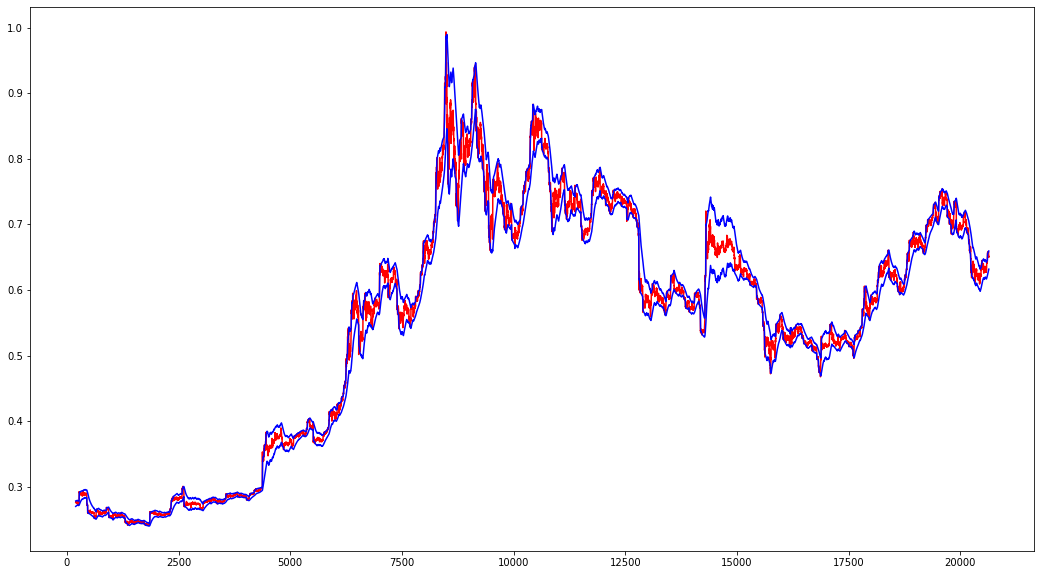

In [99]:
# 스케일 후 plot
plt.plot(copy_data.hlc3, 'r')
plt.plot(copy_data.H, color='b')
plt.plot(copy_data.L, color='b')

In [102]:
# 컬럼별 상관관계
copy_data.corr()

,open,high,low,close,Mean,Upper,Lower,Upper fib,low fib,Plot,Plot.1,Plot.2,ParabolicSAR,H,M,L,RES,SUP,EMA_34,short_line,VWAP,34 EMA,Volume,Volume.1,A/D Volume,OnBalanceVolume,MF,Accumulation/Distribution,hlc3,change,label
open,1.000000,0.999900,0.999845,0.999834,0.996394,0.993827,0.992386,0.995716,0.995246,0.993622,0.994498,0.991908,0.998019,0.996353,0.997735,0.996152,0.966982,0.903549,0.998854,0.998848,0.766849,0.995026,0.080849,0.358728,0.241383,0.970771,-0.062528,0.882350,0.999907,NaN,NaN
high,0.999900,1.000000,0.999773,0.999906,0.996326,0.994126,0.991906,0.995847,0.994966,0.993644,0.994332,0.991541,0.997853,0.996500,0.997651,0.995814,0.966937,0.902450,0.998754,0.998749,0.765369,0.994905,0.087498,0.365610,0.247676,0.970422,-0.060573,0.881309,0.999941,NaN,NaN
low,0.999845,0.999773,1.000000,0.999896,0.996257,0.993264,0.992728,0.995347,0.995355,0.993300,0.994411,0.992070,0.997725,0.995898,0.997551,0.996266,0.966873,0.904841,0.998671,0.998634,0.768743,0.994902,0.070809,0.348209,0.233128,0.971279,-0.062325,0.883687,0.999936,NaN,NaN
close,0.999834,0.999906,0.999896,1.000000,0.996283,0.993730,0.992260,0.995612,0.995127,0.993475,0.994351,0.991760,0.997776,0.996217,0.997592,0.996002,0.966859,0.903444,0.998713,0.998693,0.766718,0.994877,0.079746,0.357304,0.240782,0.970814,-0.059779,0.882278,0.999981,NaN,NaN
Mean,0.996394,0.996326,0.996257,0.996283,1.000000,0.997105,0.996336,0.999146,0.999033,0.998417,0.999274,0.996645,0.995975,0.997870,0.999358,0.997886,0.973266,0.910300,0.998339,0.997820,0.776080,0.999016,0.077627,0.354569,0.238935,0.970595,-0.082550,0.888601,0.996335,NaN,NaN
Upper,0.993827,0.994126,0.993264,0.993730,0.997105,1.000000,0.986948,0.999395,0.992796,0.997236,0.995016,0.989127,0.993227,0.998465,0.996748,0.991771,0.971287,0.895127,0.995627,0.995290,0.755838,0.995964,0.106412,0.382633,0.260757,0.964234,-0.072466,0.873924,0.993755,NaN,NaN
Lower,0.992386,0.991906,0.992728,0.992260,0.996336,0.986948,1.000000,0.991952,0.999133,0.992837,0.997148,0.998204,0.992173,0.990295,0.995378,0.997858,0.968756,0.921065,0.994481,0.993760,0.793475,0.995535,0.044717,0.320554,0.212738,0.971033,-0.093320,0.898959,0.992343,NaN,NaN
Upper fib,0.995716,0.995847,0.995347,0.995612,0.999146,0.999395,0.991952,1.000000,0.996362,0.998493,0.997679,0.993277,0.995198,0.998911,0.998658,0.995281,0.972890,0.902710,0.997583,0.997163,0.765639,0.998076,0.093324,0.370074,0.250965,0.967837,-0.077130,0.881265,0.995650,NaN,NaN
low fib,0.995246,0.994966,0.995355,0.995127,0.999033,0.992796,0.999133,0.996362,1.000000,0.996463,0.999097,0.998360,0.994932,0.994890,0.998227,0.998786,0.971839,0.916669,0.997270,0.996647,0.785736,0.998142,0.060776,0.337404,0.225684,0.971710,-0.088163,0.894741,0.995196,NaN,NaN
Plot,0.993622,0.993644,0.993300,0.993475,0.998417,0.997236,0.992837,0.998493,0.996463,1.000000,0.998388,0.993134,0.993383,0.997514,0.997825,0.995068,0.971926,0.903866,0.996465,0.995945,0.767756,0.997605,0.087616,0.362161,0.244473,0.967596,-0.081491,0.882595,0.993520,NaN,NaN


In [0]:
# ML 테스트는 label 값이 존재 해야함 
# 해당 봉의 feature 값은 다음봉의 가격 변동과 관련있다



In [0]:
class BTCDataset(Dataset):
    def __init__(self, data, x_frames, y_frames):
        self.data = data
        self.x_frames = x_frames
        self.y_frames = y_frames
    
    def __len__(self):
        return len(self.data) - (self.x_frames + self.y_frames) + 1

    def __getitem__(self, idx):
        idx += self.x_frames
        data = self.data.iloc[idx - self.x_frames : idx + self.y_frames]
        # data = data.apply(lambda x: np.log(x + 1) - np.log(x[self.x_frames -1] + 1))
        data = data.values
        X = data[: self.x_frames]
        y = data[self.x_frames: ]
        return X, y

In [0]:
# LSTM 

class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers, batch_size, dropout):
        super(LSTM, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.num_layers = num_layers
        self.batch_size = batch_size
        self.dropout = dropout

        self.lstm = nn.LSTM(self.input_dim, self.hidden_dim, self.num_layers)
        self.hidden = self.init_hidden()
        self.regressor = self.make_regressor()

    def init_hidden(self):
        return(torch.zeros(self.num_layers, self.batch_size, self.hidden_dim),
               torch.zeros(self.num_layers, self.batch_size, self.hidden_dim))
        
    def make_regressor(self):
        layers = []
        layers.append(nn.BatchNorm1d(self.hidden_dim))
        layers.append(nn.Dropout(self.dropout))

        layers.append(nn.Linear(self.hidden_dim, self.hidden_dim // 2))
        layers.append(nn.ReLU())
        layers.append(nn.Linear(self.hidden_dim // 2, self.output_dim))
        
        regressor = nn.Sequential(*layers)
        return regressor

    def forward(self, x):
        lstm_out, self.hidden = self.lstm(x, self.hidden)
        y_pred = self.regressor(lstm_out[-1].view(self.batch_size, -1))
        return y_pred

In [0]:
#   하이퍼 파라미터 설정 
EPOCHS = 1000
INPUT_SIZE = 28     # input dimension
HIDDEN_SIZE = 34    # hidden dimension
OUTPUT_SIZE = 2
BATCH_SIZE = 32
NUM_LAYERS = 1
LENGTH = 7
DROPOUT = 0.5
LR = 0.005
L2 = 0.00001

In [0]:
def train(model, partition, optimizer, loss_fn):
    trainloader = DataLoader(partition,
                             batch_size=BATCH_SIZE,
                             shuffle=True,
                             drop_last=True)   
    model.train()
    model.zero_grad()
    optimizer.zero_grad()

    train_acc = 0.0
    train_loss = 0.0
    for i, (X, y) in enumerate(trainloader):
        X = X.transpose(0, 1).float().to("cuda")
        y_true = y[:, :, 3].float().to("cuda")

        model.zero_grad()
        optimizer.zero_grad()
        model.hidden = [hidden.to("cuda") for hidden in model.init_hidden()]

        y_pred = model(X)
        loss = loss_fn(y_pred.view(-1), y_true.view(-1))
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    train_loss = train_loss / len(trainloader)
    return model, train_loss

In [0]:
train_size = int(len(copy_data) * 0.8)

train_data = BTCDataset(copy_data[:train_size], LENGTH, OUTPUT_SIZE)
test_data = BTCDataset(copy_data[train_size:], LENGTH, OUTPUT_SIZE)

model = LSTM(INPUT_SIZE, HIDDEN_SIZE, OUTPUT_SIZE, NUM_LAYERS, BATCH_SIZE, DROPOUT)
model.to("cuda")
loss_fn = torch.nn.MSELoss()
optimizer = optim.RMSprop(model.parameters(), lr=LR, weight_decay=L2)

for epoch in range(EPOCHS):
    model, train_loss = train(model, train_data, optimizer, loss_fn)
    if epoch%100 == 0:
        print(f'Epoch {epoch}, Loss {train_loss}')




Epoch 0, Loss 0.01120651784037952
Epoch 100, Loss 0.0012060984826758594
Epoch 200, Loss 0.0014605778711163165
Epoch 300, Loss 0.0011893226433540786
Epoch 400, Loss 0.0013391313442387435
Epoch 500, Loss 0.001189096799826788
Epoch 600, Loss 0.0011663631708406861
Epoch 700, Loss 0.0011900209058783766
Epoch 800, Loss 0.0011828447569688946
Epoch 900, Loss 0.001116753135740474


In [0]:
def metric(y_pred, y_true):
    perc_y_pred = y_pred.cpu().detach().numpy()
    perc_y_true = y_true.cpu().detach().numpy()
    mae = mean_absolute_error(perc_y_true, perc_y_pred, multioutput='raw_values')
    return mae*100

In [0]:
def test(model, partition):
    testloader = DataLoader(partition,
                            batch_size=BATCH_SIZE,
                            shuffle=False,
                            drop_last=True)
    model.eval()

    test_acc = 0.0
    with torch.no_grad():
        for i, (X, y) in enumerate(testloader):
            X = X.transpose(0, 1).float().to('cuda')
            y_true = y[:, :, 3].float().to('cuda')
            model.hidden = [hidden.to('cuda') for hidden in model.init_hidden()]
            y_pred = model(X)
            print(f'predict : {y_pred[0]}')
            print(f'real : {y_true[0]}')
            test_acc += metric(y_pred, y_true)[0]

    test_acc = test_acc / len(testloader)
    return test_acc        

In [0]:
print(test(model, test_data))

predict : tensor([0.5168, 0.5146, 0.5093, 0.5083], device='cuda:0')
real : tensor([0.5144, 0.5148, 0.5154, 0.5150], device='cuda:0')
predict : tensor([0.5160, 0.5138, 0.5086, 0.5076], device='cuda:0')
real : tensor([0.5207, 0.5200, 0.5213, 0.5206], device='cuda:0')
predict : tensor([0.5194, 0.5171, 0.5113, 0.5102], device='cuda:0')
real : tensor([0.5093, 0.5105, 0.5100, 0.5098], device='cuda:0')
predict : tensor([0.5191, 0.5168, 0.5111, 0.5100], device='cuda:0')
real : tensor([0.5088, 0.5091, 0.5086, 0.5102], device='cuda:0')
predict : tensor([0.5257, 0.5231, 0.5163, 0.5150], device='cuda:0')
real : tensor([0.4956, 0.4948, 0.4876, 0.4859], device='cuda:0')
predict : tensor([0.5275, 0.5248, 0.5177, 0.5163], device='cuda:0')
real : tensor([0.5130, 0.5180, 0.5134, 0.5169], device='cuda:0')
predict : tensor([0.5220, 0.5195, 0.5133, 0.5121], device='cuda:0')
real : tensor([0.5126, 0.5112, 0.5109, 0.5126], device='cuda:0')
predict : tensor([0.5193, 0.5170, 0.5112, 0.5101], device='cuda:0')
r